## Ejemplo de calibración en algoritmos de aprendizaje automático

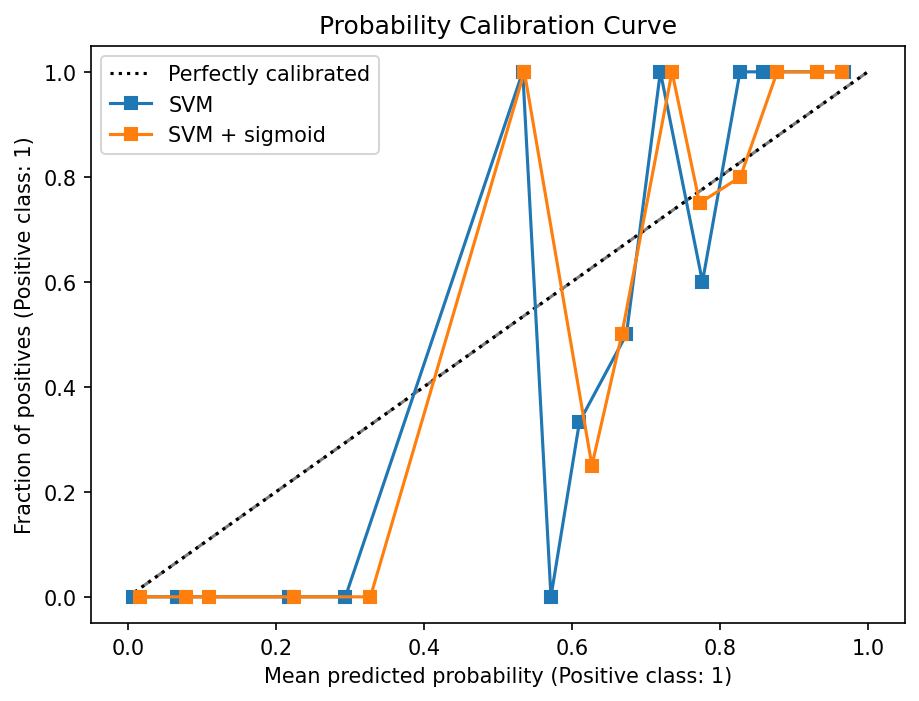

In [ ]:

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

# Load the Breast Cancer dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classifiers
svc = SVC(probability=True)
tree = DecisionTreeClassifier()
log = LogisticRegression(C=0.5)
gnb = GaussianNB()

svc_sigmoid = CalibratedClassifierCV(svc, cv=3, method="sigmoid", ensemble=True)
tree_isotonic = CalibratedClassifierCV(tree, cv=3, method="isotonic", ensemble=True)
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=3, method="sigmoid", ensemble=True)
log_sigmoid = CalibratedClassifierCV(log, cv=3, method="sigmoid", ensemble=True)

classifiers = {
    "SVM": svc,
    "SVM + sigmoid": svc_sigmoid,
}

# Plot Probability Calibration curve for each classifier
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    clf_disp = CalibrationDisplay.from_estimator(clf, X_test, y_test, n_bins=20, name=name, ax=ax)

plt.title('Probability Calibration Curve')
plt.legend(loc="best")
plt.show()

# Calibración de redes neuronales

## Preparando datos: Fashion dataset

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

### Funciones auxiliares para tratar con los datos

In [ ]:
def reduceClass(idx_class, rate, train_images, train_labels):
    """
    Reduce un porcentaje de los datos de una clase específica en los conjuntos train_images y train_labels.

    Parámetros:
    - idx_class: el índice de la clase que se desea reducir.
    - rate: el porcentaje de reducción deseado, expresado como un número entre 0 y 1.
    - train_images: el conjunto de imágenes de entrenamiento.
    - train_labels: el conjunto de etiquetas de entrenamiento.

    Devuelve:
    - train_images_reduced: el conjunto de imágenes de entrenamiento reducido.
    - train_labels_reduced: el conjunto de etiquetas de entrenamiento reducido.
    """
    # Encontrar los índices de las muestras pertenecientes a la clase específica
    idx_class_samples = np.where(train_labels == idx_class)[0]

    # Determinar el número de muestras a reducir
    num_samples_to_reduce = int(len(idx_class_samples) * rate)

    # Seleccionar aleatoriamente las muestras a reducir
    samples_to_reduce = np.random.choice(idx_class_samples, size=num_samples_to_reduce, replace=False)

    # Eliminar las muestras seleccionadas de los conjuntos de entrenamiento
    train_images_reduced = np.delete(train_images, samples_to_reduce, axis=0)
    train_labels_reduced = np.delete(train_labels, samples_to_reduce, axis=0)

    return train_images_reduced, train_labels_reduced

#Función que muestra algunas imágenes del conjunto de datos proporcionado por parámetro.
def muestraImagenes(train_images, train_labels, class_names, numImagenes=25):
  plt.figure(figsize=(10,10))
  for i in range(numImagenes):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(train_images[i], cmap=plt.cm.binary)
      plt.xlabel(class_names[train_labels[i]])
  plt.show()

#Función que crea un generador de datos con aumentado.
def creaGeneradorAumentados():
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator(
          rotation_range=20,      # Rango de rotación aleatoria en grados
          width_shift_range=0.1,  # Rango de desplazamiento aleatorio horizontal
          height_shift_range=0.1, # Rango de dcizallamientoesplazamiento aleatorio vertical
          shear_range=0.2,        # Rango de  aleatorio
          zoom_range=0.2,         # Rango de zoom aleatorio
          horizontal_flip=True,   # Volteo aleatorio horizontal
          fill_mode='nearest'     # Estrategia de relleno para valores fuera del límite de la imagen
      )
    return datagen


def generar_batches_aumentados(datagen, images, labels, batch_size=32):
    """
    Genera batches de imágenes aumentadas utilizando un generador de datos.

    Parámetros:
    - datagen: Generador de datos para la aumentación de imágenes.
    - images: Conjunto de imágenes.
    - labels: Etiquetas correspondientes a las imágenes.
    - batch_size: Tamaño del batch.

    Devuelve:
    - Un generador que produce batches de imágenes aumentadas y etiquetas.
    """

    images_expanded = np.expand_dims(images, axis=-1)

    # Crear un generador de batches de imágenes aumentadas
    data_generator = datagen.flow(images_expanded, labels, batch_size=batch_size)

    # Iterar sobre el generador para obtener batches de datos aumentados
    for images_batch, labels_batch in data_generator:
        yield images_batch.reshape(len(images_batch), images_batch.shape[1], images_batch.shape[2]), labels_batch


#Función que entrena un modelo utilizando técnicas de aumentado de datos.
def entrenaConGeneradorAumentados(model, train_images, train_labels, val_images, val_labels, epochs, batch_size):
    datagen = creaGeneradorAumentados()
    gen = generar_batches_aumentados(datagen, train_images, train_labels, batch_size)
    return model.fit(gen,
                        steps_per_epoch=len(train_images) // batch_size,
                        epochs=epochs,
                        validation_data=(val_images, val_labels))


### Carga los datos en memoria

2.15.0
Train: (6728, 28, 28) | (6728,)
Val: (12000, 28, 28) | (12000,)
Test: (10000, 28, 28) | (10000,)


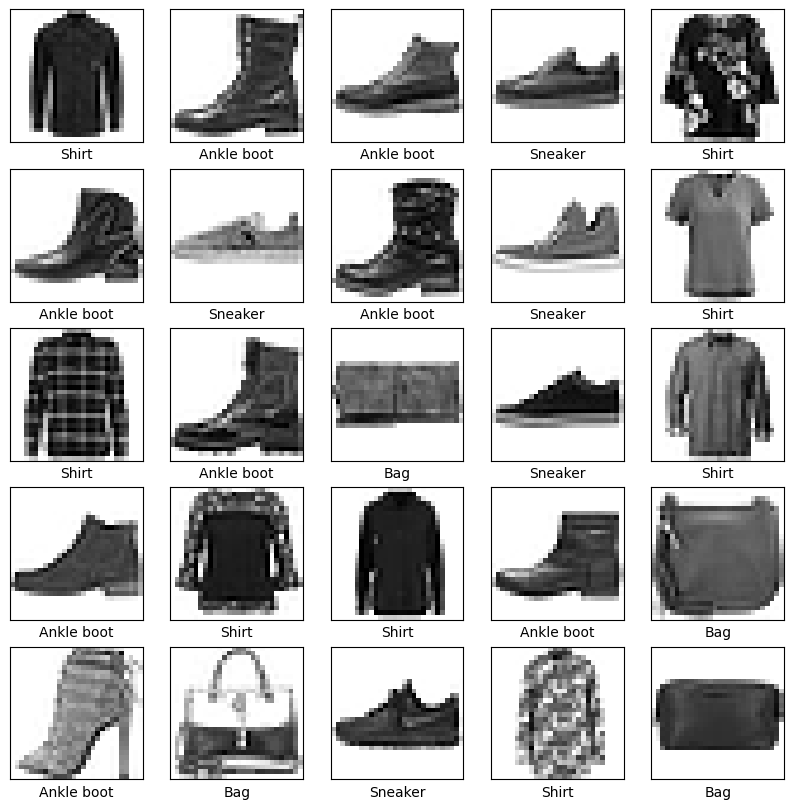

In [ ]:
import tensorflow as tf
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

#Import Dataset
#Tienes más datasets en https://www.tensorflow.org/api_docs/python/tf/keras/datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#Si queremos limitar el número de clases...
#class_names, train_images, train_labels, test_images, test_labels = reducirNumeroClases(class_names, train_images, train_labels, test_images, test_labels)


#Separar una partición de validación a partir del conjunto de entrenamiento
rate_val = 0.2
val_images = train_images[0:int(len(train_images)*rate_val)]
val_labels = train_labels[0:int(len(train_labels)*rate_val)]
train_images = train_images[int(len(train_images)*rate_val):]
train_labels = train_labels[int(len(train_labels)*rate_val):]

#Se normalizan las imágenes para que los datos tengan valores entre 0 y 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images / 255.0

#Reducir cantidad de datos de algunas clases
train_images, train_labels = reduceClass(0, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(1, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(2, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(3, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(4, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(5, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(6, 0.70, train_images, train_labels)
train_images, train_labels = reduceClass(7, 0.70, train_images, train_labels)
train_images, train_labels = reduceClass(8, 0.70, train_images, train_labels)
train_images, train_labels = reduceClass(9, 0.50, train_images, train_labels)

#Muestra en consola información sobre las particiones
print("Train: " + str(train_images.shape) + " | " + str(train_labels.shape))
print("Val: " + str(val_images.shape) + " | " + str(val_labels.shape))
print("Test: " + str(test_images.shape) + " | " + str(test_labels.shape))

#Se muestran algunos ejemplos de las imágenes cargadas.
muestraImagenes(train_images, train_labels, class_names, numImagenes=25)

## Redes neuronales de ejemplo

In [ ]:

def createModel1(): #Model

    inputs = tf.keras.layers.Input(shape=(28, 28))

    f = tf.keras.layers.Flatten() (inputs)

    # Hidden dense layer
    x = tf.keras.layers.Dense(128, activation='relu')(f)

    # Dense layer (without activation)
    x = tf.keras.layers.Dense(len(class_names))(x)

    # Output layer with softmax activation
    outputs = tf.keras.layers.Activation('softmax')(x)


    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def createModel2():
    """Create a more complex neural network model.

    Returns:
    model : tf.keras.Model
        The compiled Keras model.
    """
    # Define input layer
    inputs = tf.keras.layers.Input(shape=(28, 28))

    # Flatten layer
    f = tf.keras.layers.Flatten()(inputs)

    # Dense layers with relu activation and dropout
    x = tf.keras.layers.Dense(512, activation='relu')(f)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # Dense layer (without activation)
    x = tf.keras.layers.Dense(len(class_names))(x)

    # Output layer with softmax activation
    outputs = tf.keras.layers.Activation('softmax')(x)

    # Create and compile the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


## Calibración del modelo

### Funciones auxiliares de calibración

In [ ]:
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import math

def calculatePositionInterval(n_bins, confidence):
    # Calculate the width of each bin
    bin_width = 1.0 / n_bins
    # Calculate the index of the interval to which the confidence belongs
    if math.isnan(confidence):
        return None, None
    idx = int(confidence // bin_width)
    # Calculate the mean value of the interval
    mean_value = (idx + 0.5) * bin_width
    return idx, mean_value

def calculateBinMeans(n_bins):

    # Calculate the width of each bin
    bin_width = 1.0 / n_bins
    # Initialize an empty list to store the mean values
    bin_means = []
    # Calculate the mean value for each bin
    for i in range(n_bins):
        mean_value = (i + 0.5) * bin_width
        bin_means.append(mean_value)
    return bin_means

def generate_lists_with_intervals(list_probs_true_total, list_probs_pred_total, n_bins=10):
    """Generate lists using intervals based on predicted probabilities.

    Parameters:
    list_probs_true_total : array-like
        Array of true probabilities.
    list_probs_pred_total : array-like
        Array of predicted probabilities.
    n_bins : int, default=10
        Number of bins to use.

    Returns:
    prob_true_in_intervals : list of lists
        List of true probabilities in each interval.
    prob_pred_intervals : list
        List of predicted probabilities intervals.
    """

    # Compute the bin edges
    bin_edges = np.linspace(0, 1, n_bins + 1)

    # Initialize lists to store probabilities in each interval
    prob_true_in_intervals = [[] for _ in range(n_bins)]
    prob_pred_intervals = calculateBinMeans(n_bins)

    # Iterate over the predicted probabilities
    for pred_prob, true_prob in zip(list_probs_pred_total, list_probs_true_total):

        idx_bin, prob_conf_bin = calculatePositionInterval(n_bins, pred_prob)
        if idx_bin is not None:
          prob_true_in_intervals[idx_bin].append(true_prob)

    # Calculate the average of true probabilities in each interval
    avg_prob_true_in_intervals = [np.mean(interval_probs) for interval_probs in prob_true_in_intervals]

    return avg_prob_true_in_intervals, prob_pred_intervals



def calibration_display_average_multiclass(classifiers, X_test, y_test, func_predict, params=None, n_bins=10, ax=None, addPerfectlyCalibrated=True):
    """Visualize average calibration of multiple classifiers for multi-class classification.

    Parameters:
    classifiers : dict
        A dictionary containing name-classifier pairs.
    X_test : array-like or iterable, shape (n_samples, n_features)
        Test samples.
    y_test : array-like, shape (n_samples,)
        True labels for X_test.
    n_bins : int, default=10
        Number of bins to use when estimating the calibration curve.
    ax : matplotlib axes, default=None
        Axes to plot the calibration curve.

    Returns:
    ax : matplotlib axes
        The axes containing the calibration plot.
    """

    if ax is None:
        fig, ax = plt.subplots()

    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])


    # Compute calibration curve for each classifier
    for name, clf in classifiers.items():
        prob_true_total = np.zeros(n_bins)
        prob_pred_total = np.zeros(n_bins)

        list_probs_true_total = []
        list_probs_pred_total = []

        for i in np.unique(y_test):
            prob_true, prob_pred = calibration_curve((y_test == i).astype(int), func_predict(clf, X_test, params)[:, i], n_bins=n_bins)
            list_probs_true_total.extend(prob_true)
            list_probs_pred_total.extend(prob_pred)

        prob_true_avg, prob_pred_avg = generate_lists_with_intervals(list_probs_true_total, list_probs_pred_total, n_bins=n_bins)

        list_probs_true_total_sorted, list_probs_pred_total_sorted = zip(*sorted(zip(list_probs_true_total, list_probs_pred_total), key=lambda x: x[1]))

        #ax.plot(prob_pred_avg, prob_true_avg, marker='o', label=name)
        ax.plot(prob_pred_avg, prob_true_avg, marker='o', label=name)

    if addPerfectlyCalibrated:
        # Add perfect calibration line
        ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')

    ax.legend(loc="lower right")

    return ax


#Función que calcula el ECE
def expected_calibration_error(classifiers, X_test, y_test, func_predict, params=None, n_bins=10):
    ece_dict = {}

    for clf_name, clf in classifiers.items():
        # Obtener las predicciones y las probabilidades de confianza del clasificador
        y_proba = func_predict(clf, X_test, params)

        # Calcular el ECE para el clasificador actual
        ece = calculate_ece(y_proba, y_test, n_bins)
        ece_dict[clf_name] = round(ece, 3)

    return ece_dict

#Función que calcula el ECE a partir de las predicciones y el ground truth.
def calculate_ece(y_proba, y_true, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences = np.max(y_proba, axis=1)
    predicted_label = np.argmax(y_proba, axis=1)
    accuracies = predicted_label == y_true
    ece = np.zeros(1)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        prop_in_bin = in_bin.astype(float).mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].astype(float).mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()

## **T-Scaling**

### Entrenamiento del modelo base

In [ ]:
modelBase_TS = createModel1()
modelBase_TS.summary()

epochs=20
batch_size = 128

tf.random.set_seed(200)


print ("Training base model...")
modelBase_TS.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=128)

#Cambia el fit anterior por la siguiente instrucción para entrenar un modelo con aumentado.
#entrenaConGeneradorAumentados(modelBase_TS, train_images, train_labels, val_images, val_labels, epochs, batch_size)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Training base model...
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892 - loss: 0.7192 - val_accuracy: 0.3792 - val_loss: 5.9744
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9447 - loss: 0.1966 - val_accuracy: 0.3821 - val_loss: 4.3293
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9521 - loss: 0.1649 - val_accuracy: 0.3838 - val_loss: 3.8511
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9560 - loss: 0.1471 - val_accuracy: 0.3968 - val_loss: 3.5650
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9600 - loss: 0.1325 - val_accuracy: 0.4174 - val_loss: 3.3230
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9629 - loss: 0.1201 - val_accuracy: 0.4269 - val_loss: 3.2124
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9664 - loss: 0.1109 - val_accuracy: 0.4353 - val_loss: 3.1526
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9684 - loss: 0.1024 - val_accur

### Calibración y resultados

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


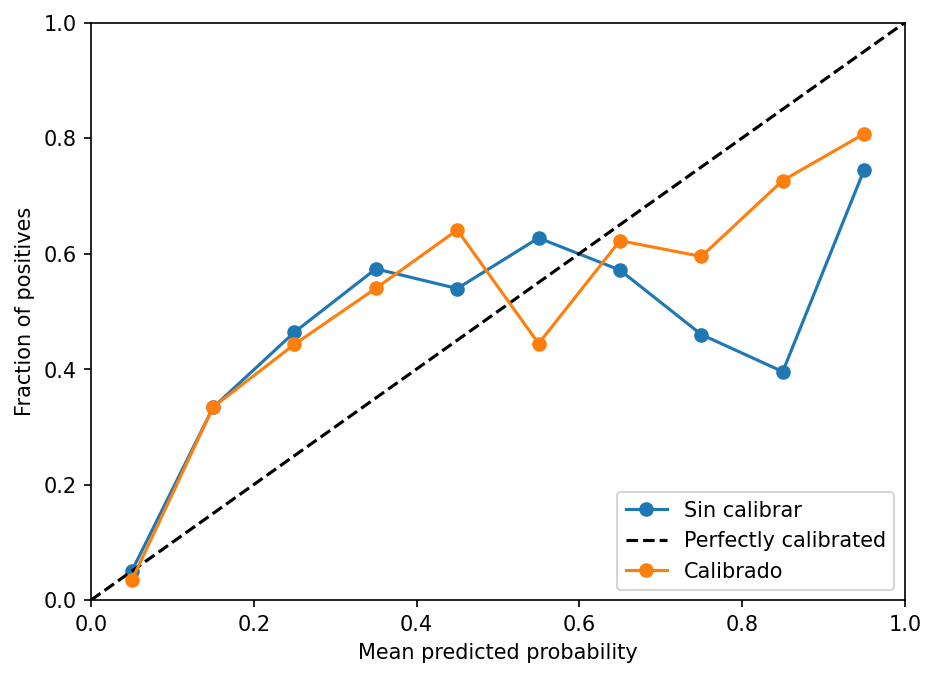

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
**************************************************
Métricas de calibración
ECE base = {'Sin calibrar': 0.472}
ECE calibrado = {'Calibrado': 0.266}


In [ ]:
def predict_tscaling(clf, X_test, temperature):
    logits_layer = clf.layers[-2]  # Obtener la capa anterior a la capa de salida softmax
    logits_model = tf.keras.Model(inputs=clf.inputs, outputs=logits_layer.output)

    logits = logits_model.predict(test_images)

    probs_calibrated = temperature_scaling(logits, temperature)

    return probs_calibrated

def predict(clf, X_test, params):
    return clf.predict(X_test)


def temperature_scaling(logits, temperature):
    """
    Aplica la técnica de temperatura a las salidas de logits de un modelo.

    Parámetros:
    - logits: un array de Numpy que contiene las salidas de logits del modelo.
    - temperature: el valor de temperatura para ajustar las salidas de logits.

    Devuelve:
    - probs: un array de Numpy que contiene las probabilidades escaladas.
    """
    logits = logits.astype(np.float64)
    # Aplicar temperatura a los logits
    scaled_logits = logits / temperature

    # Calcular las probabilidades softmax escaladas
    exp_logits = np.exp(scaled_logits)

    probs = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

    return probs


temperature = 2.75 # Ajusta la temperatura según sea necesario

#Lista de clasificadores que se van a evaluar
classifiersTS = {
    #"Sin calibrar" : modelBase_TS,
    "Calibrado" : modelBase_TS
}

classifiersNormal = {
    "Sin calibrar" : modelBase_TS,
    #"Calibrado" : modelBase_TS
}



# Muestra los resultados de calibración de Plat Scaling
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

n_bins = 10
calibration_display_average_multiclass(classifiersNormal, test_images, test_labels, predict, params=None, n_bins=n_bins, ax=ax, addPerfectlyCalibrated=True)
calibration_display_average_multiclass(classifiersTS, test_images, test_labels, predict_tscaling, params=temperature, n_bins=n_bins, ax=ax, addPerfectlyCalibrated=False)
plt.show()


ece_base = expected_calibration_error(classifiersNormal, test_images, test_labels, predict, params=None, n_bins=10)
ece_tscaling = expected_calibration_error(classifiersTS, test_images, test_labels, predict_tscaling, params=temperature, n_bins=10)

print('*'*50)
print("Métricas de calibración")
print("ECE base = " + str(ece_base))
print("ECE calibrado = " + str(ece_tscaling))


## Calibración de Modelos con el método T-Scaling

Train: (6728, 28, 28) | (6728,)
Val: (12000, 28, 28) | (12000,)
Test: (10000, 28, 28) | (10000,)


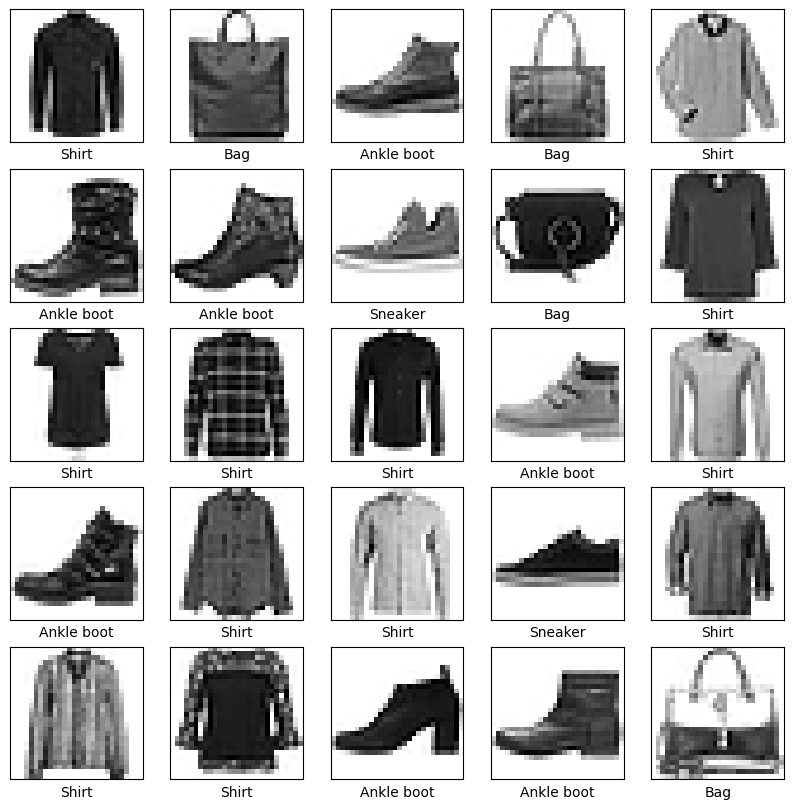

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#Separar una partición de validación a partir del conjunto de entrenamiento
rate_val = 0.2
val_images = train_images[0:int(len(train_images)*rate_val)]
val_labels = train_labels[0:int(len(train_labels)*rate_val)]
train_images = train_images[int(len(train_images)*rate_val):]
train_labels = train_labels[int(len(train_labels)*rate_val):]

#Se normalizan las imágenes para que los datos tengan valores entre 0 y 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images / 255.0

#Reducir cantidad de datos de algunas clases
train_images, train_labels = reduceClass(0, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(1, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(2, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(3, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(4, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(5, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(6, 0.70, train_images, train_labels)
train_images, train_labels = reduceClass(7, 0.70, train_images, train_labels)
train_images, train_labels = reduceClass(8, 0.70, train_images, train_labels)
train_images, train_labels = reduceClass(9, 0.50, train_images, train_labels)

#Muestra en consola información sobre las particiones
print("Train: " + str(train_images.shape) + " | " + str(train_labels.shape))
print("Val: " + str(val_images.shape) + " | " + str(val_labels.shape))
print("Test: " + str(test_images.shape) + " | " + str(test_labels.shape))

#Se muestran algunos ejemplos de las imágenes cargadas.
muestraImagenes(train_images, train_labels, class_names, numImagenes=25)

In [ ]:
# Entrenamiento del modelo

modelo = createModel2()
modelo.summary()

epochs=20
batch_size = 128

tf.random.set_seed(200)

modelo.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=128, verbose=0)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_results = modelo.evaluate(train_images, train_labels, verbose=0)
val_results = modelo.evaluate(val_images, val_labels, verbose=0)
trest_results = modelo.evaluate(test_images, test_labels, verbose=0)

print("Resultados del modelo en datos de entrenamiento:")
print("Accuracy:", train_results[1])

print("\nResultados del modelo en datos de validación:")
print("Accuracy:", val_results[1])

print("\nResultados del modelo en datos de test:")
print("Accuracy:", trest_results[1])

Resultados del modelo en datos de entrenamiento:
Accuracy: 0.9802318811416626

Resultados del modelo en datos de validación:
Accuracy: 0.4830833375453949

Resultados del modelo en datos de test:
Accuracy: 0.4745999872684479


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
313/313 ━━━

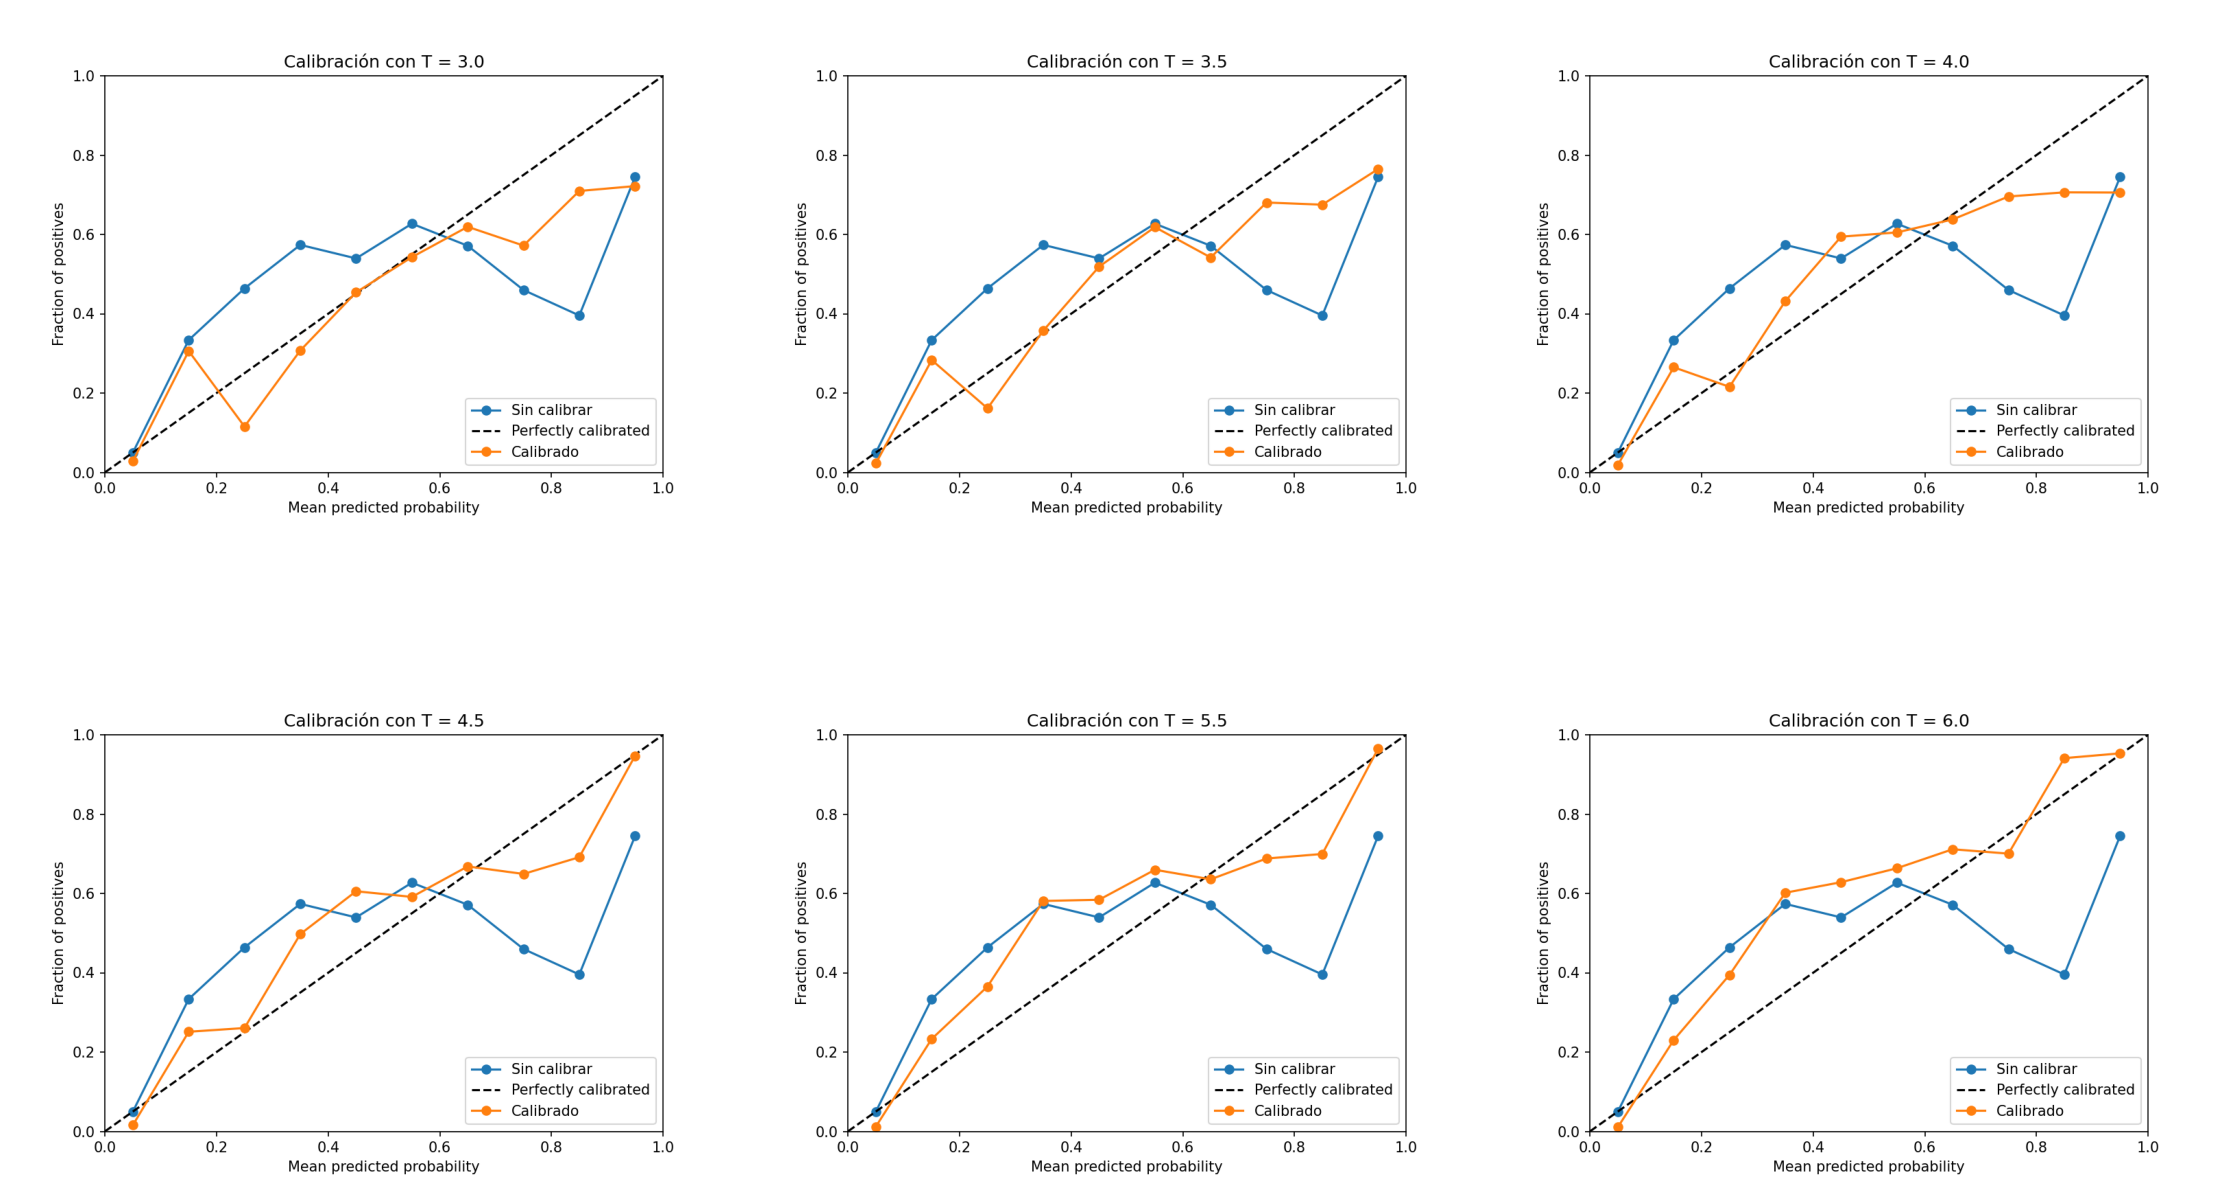

**************************************************
Resultados de ECE para cada temperatura:
T = 3.0:
  ECE base = {'Sin calibrar': 0.472}
  ECE calibrado = {'Calibrado': 0.166}
T = 3.5:
  ECE base = {'Sin calibrar': 0.472}
  ECE calibrado = {'Calibrado': 0.109}
T = 4.0:
  ECE base = {'Sin calibrar': 0.472}
  ECE calibrado = {'Calibrado': 0.065}
T = 4.5:
  ECE base = {'Sin calibrar': 0.472}
  ECE calibrado = {'Calibrado': 0.052}
T = 5.5:
  ECE base = {'Sin calibrar': 0.472}
  ECE calibrado = {'Calibrado': 0.07}
T = 6.0:
  ECE base = {'Sin calibrar': 0.472}
  ECE calibrado = {'Calibrado': 0.084}


In [ ]:
temperatures = [3.0, 3.5, 4.0, 4.5, 5.5, 6.0]

file_names = []
ece_results = []

for temperature in temperatures:
    classifiersTS = {"Calibrado": modelo}

    fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
    calibration_display_average_multiclass(classifiersNormal, test_images, test_labels, predict, params=None, n_bins=n_bins, ax=ax, addPerfectlyCalibrated=True)
    calibration_display_average_multiclass(classifiersTS, test_images, test_labels, predict_tscaling, params=temperature, n_bins=n_bins, ax=ax, addPerfectlyCalibrated=False)
    ax.set_title(f"Calibración con T = {temperature}")

    # Guardar la figura para despues leerla
    file_name = f"calibration_plot_T_{temperature}.png"
    fig.savefig(file_name)
    plt.close(fig)
    file_names.append(file_name)

    ece_base = expected_calibration_error(classifiersNormal, test_images, test_labels, predict, params=None, n_bins=10)
    ece_tscaling = expected_calibration_error(classifiersTS, test_images, test_labels, predict_tscaling, params=temperature, n_bins=10)
    ece_results.append((ece_base, ece_tscaling))

fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=150)

for i, file_name in enumerate(file_names):
    row = i // 3
    col = i % 3
    img = plt.imread(file_name)
    axs[row, col].imshow(img)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

print('*' * 50)
print("Resultados de ECE para cada temperatura:")
for temperature, ece_result in zip(temperatures, ece_results):
    ece_base, ece_tscaling = ece_result
    print(f"T = {temperature}:")
    print("  ECE base =", ece_base)
    print("  ECE calibrado =", ece_tscaling)

In [ ]:
temperature = 4.5

predicciones_calibradas = predict_tscaling(modelo, test_images, temperature)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


In [ ]:
from sklearn.metrics import accuracy_score

predicciones_calibradas_etiquetas = np.argmax(predicciones_calibradas, axis=1)

precision_calibrada = accuracy_score(test_labels, predicciones_calibradas_etiquetas)

print("Precisión del modelo con predicciones calibradas:", precision_calibrada)


Precisión del modelo con predicciones calibradas: 0.4746


## Aumentación de los datos de entrenamiento

Train: (8436, 28, 28) | (8436,)
Test: (10000, 28, 28) | (10000,)


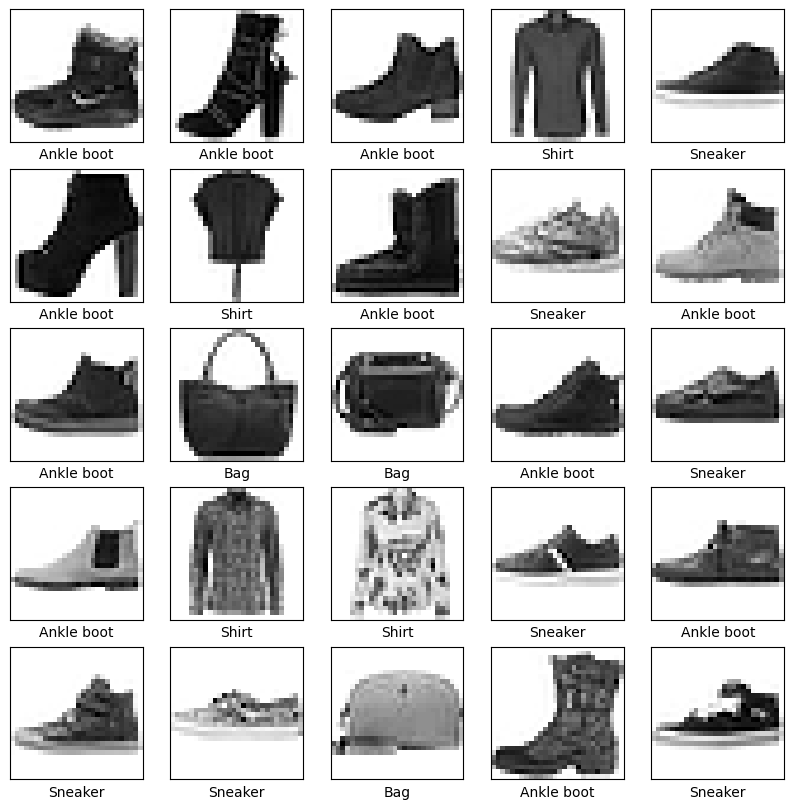

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Se normalizan las imágenes para que los datos tengan valores entre 0 y 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

#Reducir cantidad de datos de algunas clases
train_images, train_labels = reduceClass(0, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(1, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(2, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(3, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(4, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(5, 0.999, train_images, train_labels)
train_images, train_labels = reduceClass(6, 0.70, train_images, train_labels)
train_images, train_labels = reduceClass(7, 0.70, train_images, train_labels)
train_images, train_labels = reduceClass(8, 0.70, train_images, train_labels)
train_images, train_labels = reduceClass(9, 0.50, train_images, train_labels)

#Muestra en consola información sobre las particiones
print("Train: " + str(train_images.shape) + " | " + str(train_labels.shape))
print("Test: " + str(test_images.shape) + " | " + str(test_labels.shape))

#Se muestran algunos ejemplos de las imágenes cargadas.
muestraImagenes(train_images, train_labels, class_names, numImagenes=25)

### Resultados del modelo sin aumento de datos.


In [ ]:
modelo2 = createModel1()

epochs=20
batch_size = 128

tf.random.set_seed(200)

modelo2.fit(train_images, train_labels, epochs=epochs, batch_size=128, verbose=0)

In [ ]:
predicciones = modelo2.predict(test_images)

etiquetas = np.argmax(predicciones, axis=1)

acc = accuracy_score(test_labels, etiquetas)

print("Accuracy:", acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
Accuracy: 0.5008


### Aumentado de imagenes - función implementada por el profesorado

In [ ]:
modelo2 = createModel1()

epochs=20
batch_size = 128

tf.random.set_seed(200)

entrenamiento = entrenaConGeneradorAumentados(modelo2, train_images, train_labels, test_images, test_labels, epochs, batch_size)

predicciones = modelo2.predict(test_images)

etiquetas = np.argmax(predicciones, axis=1)

acc = accuracy_score(test_labels, etiquetas)

print("Accuracy:", acc)


Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6516 - loss: 1.0041 - val_accuracy: 0.3684 - val_loss: 6.3605
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8567 - loss: 0.4585 - val_accuracy: 0.3651 - val_loss: 5.4646
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8918 - loss: 0.3656 - val_accuracy: 0.3658 - val_loss: 4.8791
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8828 - loss: 0.3615 - val_accuracy: 0.3666 - val_loss: 4.6954
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8926 - loss: 0.3285 - val_accuracy: 0.3645 - val_loss: 4.7134
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9051 - loss: 0.3177 - val_accuracy: 0.3756 - val_loss: 4.4622
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8976 - loss: 0.3016 - val_accuracy: 0.3706 - val_loss: 4.4950
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8950 - loss: 0.3284 - val_accuracy: 0.3675 - val_los

### Aumentado con giros de 180

Shape train_images: (16872, 28, 28)
Shape train_labels: (16872,)


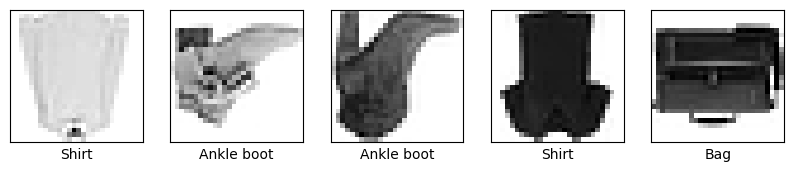

In [ ]:
def rotate_images_180(images):
    rotated_images = np.rot90(images, k=2, axes=(1, 2))
    return rotated_images

rotadas = rotate_images_180(train_images)

train_rotadas = np.concatenate((train_images, rotadas), axis=0)

train_labels_rotadas = np.concatenate((train_labels, train_labels), axis=0)

print("Shape train_images:", train_rotadas.shape)
print("Shape train_labels:", train_labels_rotadas.shape)

# Nueva funcion para mostrar las ultimas imagenes
def muestraImagenes2(train_images, train_labels, class_names, numImagenes=25):
    plt.figure(figsize=(10,10))
    start_index = len(train_images) - numImagenes  # Índice de inicio para las últimas numImagenes imágenes
    for i in range(numImagenes):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[start_index + i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[start_index + i]])
    plt.show()


muestraImagenes2(train_rotadas, train_labels_rotadas, class_names, numImagenes=5)

In [ ]:
modelo2 = createModel1()

epochs=20
batch_size = 128

tf.random.set_seed(200)

modelo2.fit(train_rotadas, train_labels_rotadas, epochs=epochs, batch_size=128, verbose=0)

predicciones = modelo2.predict(test_images)

etiquetas = np.argmax(predicciones, axis=1)

acc = accuracy_score(test_labels, etiquetas)

print("Accuracy:", acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
Accuracy: 0.4973


### Aumentado con efecto espejo

In [ ]:
def mirror_images(images):
    mirrored_images = np.flip(images, axis=2)
    return mirrored_images


espejo = mirror_images(train_images)

train_espejo = np.concatenate((train_images, espejo), axis=0)

train_labels_espejo = np.concatenate((train_labels, train_labels), axis=0)

In [ ]:
modelo2 = createModel1()

epochs=20
batch_size = 128

tf.random.set_seed(200)

modelo2.fit(train_espejo, train_labels_espejo, epochs=epochs, batch_size=128, verbose=0)

predicciones = modelo2.predict(test_images)

etiquetas = np.argmax(predicciones, axis=1)

acc = accuracy_score(test_labels, etiquetas)

print("Accuracy:", acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
Accuracy: 0.5053


### Aumentado con imagenes con ruido

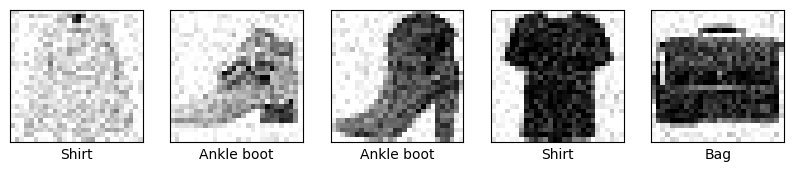

In [ ]:
def add_noise_to_images(images, noise_factor=0.1):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)  # Asegura que los valores estén en el rango [0, 1]
    return noisy_images


ruido = add_noise_to_images(train_images)

train_ruido = np.concatenate((train_images, ruido), axis=0)

train_labels_ruido = np.concatenate((train_labels, train_labels), axis=0)

muestraImagenes2(train_ruido, train_labels_ruido, class_names, numImagenes=5)

In [ ]:
modelo2 = createModel1()

epochs=20
batch_size = 128

tf.random.set_seed(200)

modelo2.fit(train_ruido, train_labels_ruido, epochs=epochs, batch_size=128, verbose=0)

predicciones = modelo2.predict(test_images)

etiquetas = np.argmax(predicciones, axis=1)

acc = accuracy_score(test_labels, etiquetas)

print("Accuracy:", acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
Accuracy: 0.5046


### Aumentado de datos con todas las transformaciones

Shape train_images: (33744, 28, 28)
Shape train_labels: (33744,)


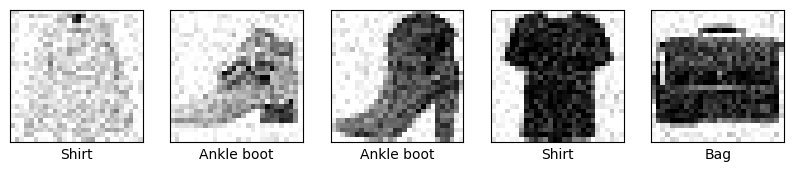

In [ ]:
train_transf = np.concatenate((train_images, rotadas, espejo, ruido) , axis=0)
train_lab_transf = np.concatenate((train_labels, train_labels, train_labels, train_labels) , axis=0)


print("Shape train_images:", train_transf.shape)
print("Shape train_labels:", train_lab_transf.shape)

muestraImagenes2(train_transf, train_lab_transf, class_names, numImagenes=5)

In [ ]:
modelo2 = createModel1()

epochs=20
batch_size = 128

tf.random.set_seed(200)

modelo2.fit(train_transf, train_lab_transf, epochs=epochs, batch_size=128, verbose=0)

predicciones = modelo2.predict(test_images)

etiquetas = np.argmax(predicciones, axis=1)

acc = accuracy_score(test_labels, etiquetas)

print("Accuracy:", acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
Accuracy: 0.5067


### Aumentado de datos con todas las transformaciones a la vez

In [ ]:
def apply_all_transformations_to_image(image, noise_factor=0.1):
    rotated_image = np.rot90(image, k=2, axes=(0, 1))

    mirrored_image = np.flip(image, axis=1)

    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)  # Asegura que los valores estén en el rango [0, 1]

    transformed_image = (rotated_image + mirrored_image + noisy_image) / 3

    return transformed_image



todas = apply_all_transformations_to_image(train_images)

train_todas = np.concatenate((train_images, todas), axis=0)

train_labels_todas = np.concatenate((train_labels, train_labels), axis=0)

In [ ]:
modelo2 = createModel1()

epochs=20
batch_size = 128

tf.random.set_seed(200)

modelo2.fit(train_todas, train_labels_todas, epochs=epochs, batch_size=128, verbose=0)

predicciones = modelo2.predict(test_images)

etiquetas = np.argmax(predicciones, axis=1)

acc = accuracy_score(test_labels, etiquetas)

print("Accuracy:", acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
Accuracy: 0.4911
